# Data Workshop, Strasbourg 2025

This workshop consists of different sections:
- [Scraping](##Scraping)
- [Visualization](##Visualization)
- [Preprocessing](##Preprocessing)
- [Predicting](##Predicting)

In each section, you will explore the code and fill the missing code when needed

## Scraping

This first section will describe the process of scraping data from the [understat.com](https://understat.com) website, that has a lot of statistical information about all football games in top 5 European football leagues.

The main information provided in the [understat.com](https://understat.com) home page is **Expected goals (xG)**, a new revolutionary football metric, which allows you to evaluate team and player performance. It is a statistical measure of the quality of chances created and conceded. 

Higher (xG) -> Expected to score more goals


The website not only shows the (xG) metric, but much more, which makes this site perfect for scraping statistical data about football games.

We start by installing the needed packages:

In [34]:
# !pip install requests beautifulsoup4 pandas numpy plotly ipywidgets seaborn matplotlib adjustText scikit-learn

In [ ]:
# Scraping
import requests # Used for HTTP requests
from bs4 import BeautifulSoup # Used for HTML parsing

# Data manipulation
import pandas as pd # Used for Data manipulation
import json
import numpy as np

# Data visualization
import plotly.graph_objs as go
from ipywidgets import interact
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from google.colab import output
output.enable_custom_widget_manager()

# Data analysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Website research and structure of data

On the home page we can notice that the site has data for 6 European Leagues:
*   La Liga
*   EPL
*   BundesLiga
*   Serie A
*   Ligue 1
*   RFPL

![leagues.jpg](https://github.com/Hadiosj/data-workshop/blob/main/data1.png?raw=true)

<br>

We can also notice that the data collected is starting from the 2014/2015 season:

![seasons.jpg](https://github.com/Hadiosj/data-workshop/blob/main/data2.png?raw=true)

<br>

Another notion we make is the structure of URL. It is `https://understat.com/league` + `/name_of_the_league` + `/year_start_of_the_season`


In [36]:
# possible urls for all seasons of all leagues
base_url = 'https://understat.com/league'
leagues = ['La_liga', 'EPL', 'Bundesliga', 'Serie_A', 'Ligue_1', 'RFPL']
seasons = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023' ,'2024']

# Create a URL based on your choice of league and season
# For example, to get the EPL 2023 season data we should use:
url = "https://understat.com/league/EPL/2023"

Run the next cell to see if your URL is valid:

In [37]:
try:
    if not url.startswith('https://understat.com/'):
        print("❌ URL must start with 'https://understat.com/'")
    else:
        response = requests.get(url)
        if response.status_code == 200:
            print(f"✅ URL is valid: {url}")
        else:
            print(f"❌ URL is invalid: {url}")
except requests.exceptions.RequestException as e:
    print(f"❌ URL is invalid: {url}")

✅ URL is valid: https://understat.com/league/EPL/2023


Next step is to understand where the data is located on the web-page. For this we open Developer Tools in Chrome, go to tab "Network", find file with data (in this case 2018) and check the "Response" tab. This is what we will get after running *requests.get(URL)*

![requests_response_1.jpg](http://sergilehkyi.com/wp-content/uploads/2019/06/requests_response_1.jpg)

After going through content of the web-page we find that the data is stored under "script" tag and it is JSON encoded. So we will need to find this tag, get JSON from it and convert it into Python readable data structure.

![requests_response_2.jpg](http://sergilehkyi.com/wp-content/uploads/2019/06/requests_response_2.jpg)

In [38]:
# Starting with latest data for Spanish league, because I'm a Barcelona fan
res = requests.get(url)
soup = BeautifulSoup(res.content, "html.parser")

# Based on the structure of the webpage, I found that data is in the JSON variable, under <script> tags
scripts = soup.find_all('script')

# Check our <script> tags
for el in scripts:
  print('*'*50)
  print(el.text)

**************************************************

			var THEME = localStorage.getItem("theme") || 'DARK';
			document.body.className = "theme-" + THEME.toLowerCase();
		
**************************************************

	var datesData 	= JSON.parse('\x5B\x7B\x22id\x22\x3A\x2222275\x22,\x22isResult\x22\x3Atrue,\x22h\x22\x3A\x7B\x22id\x22\x3A\x2292\x22,\x22title\x22\x3A\x22Burnley\x22,\x22short_title\x22\x3A\x22BUR\x22\x7D,\x22a\x22\x3A\x7B\x22id\x22\x3A\x2288\x22,\x22title\x22\x3A\x22Manchester\x20City\x22,\x22short_title\x22\x3A\x22MCI\x22\x7D,\x22goals\x22\x3A\x7B\x22h\x22\x3A\x220\x22,\x22a\x22\x3A\x223\x22\x7D,\x22xG\x22\x3A\x7B\x22h\x22\x3A\x220.311032\x22,\x22a\x22\x3A\x222.40074\x22\x7D,\x22datetime\x22\x3A\x222023\x2D08\x2D11\x2019\x3A00\x3A00\x22,\x22forecast\x22\x3A\x7B\x22w\x22\x3A\x220.0177\x22,\x22d\x22\x3A\x220.0854\x22,\x22l\x22\x3A\x220.8969\x22\x7D\x7D,\x7B\x22id\x22\x3A\x2222276\x22,\x22isResult\x22\x3Atrue,\x22h\x22\x3A\x7B\x22id\x22\x3A\x2283\x22,\x22title\x22\x3

### Working with JSON

We found that the data interesting to us is stored in `teamsData` variable, after creating a soup of html tags it becomes just a string, so we find that text and extract JSON from it.

In [39]:
string_with_json_obj = ''

# Find data for teams
for script in scripts:
    if 'teamsData' in str(script):
        string_with_json_obj = str(script).strip()

# strip unnecessary symbols and get only JSON data
ind_start = string_with_json_obj.index("('")+2
ind_end = string_with_json_obj.index("')")
json_data = string_with_json_obj[ind_start:ind_end]

json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)

Once we have gotten our JSON and cleaned it up we can convert it into Python dictionary and check how it looks.

### Understanding data with Python

In [40]:
# convert JSON data into Python dictionary

# print(data.keys())
# print('='*50)
# print(data['138'].keys())
# print('='*50)
# print(data['138']['id'])
# print('='*50)
# print(data['138']['title'])
# print('='*50)
# print(data['138']['history'][0])

# Print pretty JSON data to check out what we have there
# s = json.dumps(data, indent=4, sort_keys=True)
# print(s)

In [41]:
rows = []

# Iterate over each team (in case there are more than one)
for team_id, team_data in data.items():
    for game in team_data['history']:
        row = {'team_name': team_data['title']}
        row.update(game)  # Merge game data
        rows.append(row)

# Create DataFrame
# columns = ['team_name', 'h_a', 'xG', 'xGA', 'scored', 'missed', 'xpts', 'result', 'pts', 'date']
# Filter columns
# df = pd.DataFrame(rows, columns=columns)
df = pd.DataFrame(rows)

df.sample(10) # check out the data

,team_name,h_a,xG,xGA,npxG,npxGA,ppda,ppda_allowed,deep,deep_allowed,scored,missed,xpts,result,date,wins,draws,loses,pts,npxGD
55,Everton,a,1.983850,1.575270,1.983850,1.575270,"{'att': 380, 'def': 44}","{'att': 169, 'def': 22}",11,10,1,2,1.6655,l,2023-12-23 15:00:00,0,0,1,0,0.408580
220,West Ham,h,1.470170,1.394230,1.470170,1.394230,"{'att': 342, 'def': 24}","{'att': 158, 'def': 28}",4,22,1,1,1.4110,d,2024-04-02 19:15:00,0,1,0,1,0.075940
435,Manchester United,a,0.730496,1.514680,0.730496,1.514680,"{'att': 153, 'def': 25}","{'att': 349, 'def': 21}",7,4,0,2,0.7029,l,2023-12-23 12:30:00,0,0,1,0,-0.784184
743,Luton,a,2.674630,2.373530,1.913460,2.373530,"{'att': 198, 'def': 28}","{'att': 192, 'def': 28}",8,9,4,4,1.6034,d,2024-02-03 15:00:00,0,1,0,1,-0.460070
656,Brentford,h,1.829440,1.755050,1.829440,1.755050,"{'att': 168, 'def': 14}","{'att': 306, 'def': 23}",9,6,3,2,1.3871,w,2023-11-04 15:00:00,1,0,0,3,0.074390
668,Brentford,a,1.849080,1.057810,1.849080,1.057810,"{'att': 317, 'def': 20}","{'att': 110, 'def': 19}",3,7,2,0,2.0106,w,2024-02-10 15:00:00,1,0,0,3,0.791270
362,Liverpool,a,1.533440,0.834585,1.533440,0.834585,"{'att': 149, 'def': 31}","{'att': 281, 'def': 28}",15,10,4,0,1.9563,w,2024-01-21 16:30:00,1,0,0,3,0.698855
278,Arsenal,a,1.826990,1.663150,1.826990,1.663150,"{'att': 115, 'def': 15}","{'att': 179, 'def': 21}",4,4,1,0,1.4506,w,2023-11-25 17:30:00,1,0,0,3,0.163840
150,Crystal Palace,a,2.514520,1.156100,2.514520,1.156100,"{'att': 330, 'def': 27}","{'att': 172, 'def': 30}",9,5,3,1,2.3549,w,2024-05-11 14:00:00,1,0,0,3,1.358420
167,Chelsea,a,0.885512,1.114370,0.885512,1.114370,"{'att': 112, 'def': 25}","{'att': 407, 'def': 28}",9,3,0,2,1.0693,l,2023-12-10 14:00:00,0,0,1,0,-0.228858


## Visualization

In [42]:
# Prepare DataFrame
df = pd.DataFrame(rows)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Ensure numeric types
df['xG'] = pd.to_numeric(df['xG'], errors='coerce')
df['scored'] = pd.to_numeric(df['scored'], errors='coerce')

# Function to plot for selected team
def plot_team_xg(team):
    team_df = df[df['team_name'] == team].copy()
    team_df = team_df.sort_values('date')
    team_df['xG_roll'] = team_df['xG'].rolling(window=5).mean()
    team_df['scored_roll'] = team_df['scored'].rolling(window=5).mean()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=team_df['date'], y=team_df['xG_roll'],
                             mode='lines', name='xG (Rolling Avg)'))
    fig.add_trace(go.Scatter(x=team_df['date'], y=team_df['scored_roll'],
                             mode='lines', name='Goals Scored (Rolling Avg)'))
    fig.update_layout(title=f'{team}: Rolling Average xG vs Goals',
                      xaxis_title='Date',
                      yaxis_title='Goals',
                      xaxis_tickformat='%b %Y',  # Short month-year format
                      xaxis=dict(tickangle=45),
                      yaxis=dict(range=[0, team_df['scored_roll'].max() + 1]),
                      template='plotly_white')
    fig.show()

# Interactive dropdown for team
teams = sorted(df['team_name'].unique())
interact(plot_team_xg, team=teams)


interactive(children=(Dropdown(description='team', options=('Arsenal', 'Aston Villa', 'Bournemouth', 'Brentfor…

<function __main__.plot_team_xg(team)>

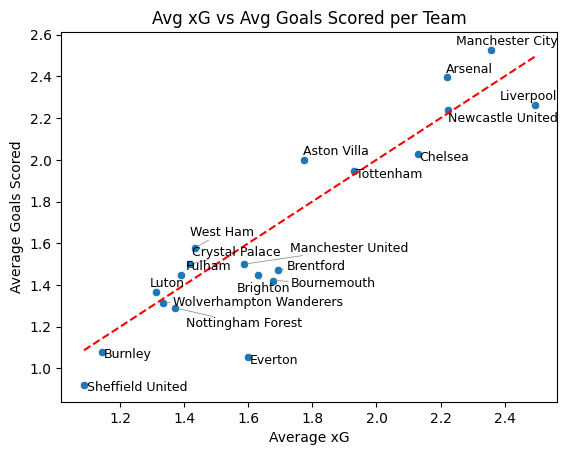

In [43]:
team_summary = df.groupby('team_name')[['xG', 'scored']].mean().reset_index()

sns.scatterplot(data=team_summary, x='xG', y='scored')

# Create a list of text annotations
texts = []
for i, row in team_summary.iterrows():
    texts.append(plt.text(row['xG'], row['scored'], row['team_name'], fontsize=9))

# Adjust text to avoid overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.plot([team_summary['xG'].min(), team_summary['xG'].max()],
         [team_summary['xG'].min(), team_summary['xG'].max()], 'r--')
plt.title('Avg xG vs Avg Goals Scored per Team')
plt.xlabel('Average xG')
plt.ylabel('Average Goals Scored')
plt.show()

### So what can we use this data for?

We want to answer the following:

> **"Does xG correlate with success? Is it a good indicator of performance?"**

By using **xG**, **xGA**, **non-penalty xG**, and similar stats to classify match outcomes (Win, Draw, Loss), we are testing:

- Whether xG-based stats explain what happened in the match
- If xG is a better metric for performance analysis than just looking at goals scored
- If it's useful to analysts, coaches, or scouts as a post-match evaluation tool

## Preprocessing

Before we can train a model to predict the number of goals scored, we need to preprocess our data. This is similar to what we'd do for classification, but our target variable will be different.

Our main preprocessing tasks will be:
1.  **Identify Target Variable**: Our target `y` will be the `scored` column, representing the actual number of goals scored by the team in a match.
2.  **Handle Categorical Features**: We'll still need to convert categorical columns like `h_a` (home/away) into a numerical format as it can influence goal scoring.
3.  **Feature Selection**: We'll choose features that we believe will be most predictive of the number of goals scored.
4.  **Data Cleaning**: Ensure all selected features and the target variable are numeric and handle any missing or infinite values.
5.  **Splitting Data**: We'll divide our dataset into a training set and a testing set.
6.  **Feature Scaling**: Scale numerical features to help the regression model perform better.

In [44]:
# Create a copy of the DataFrame to avoid modifying the original
df_regr = df.copy()

In [45]:
# 1. Identify Target Variable & 4. Data Cleaning (Target)
# Ensure 'scored' is numeric and handle missing/infinite values
df_regr['scored'] = pd.to_numeric(df_regr['scored'], errors='coerce')
df_regr.dropna(subset=['scored'], inplace=True) # Drop rows where 'scored' is NaN after coercion
df_regr['scored'] = df_regr['scored'].astype(int) # Goals are integers

In [46]:
# 2. Handle Categorical Features
df_regr['h_a'] = df_regr['h_a'].apply(lambda x: 1 if x == 'h' else 0)

# 4. Data Cleaning (Features)
# Define potential features and ensure they are clean
feature_cols = ['h_a', 'xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed', 'xpts', 'pts', 'npxGD']
df_regr.dropna(subset=feature_cols, inplace=True) # Drop rows with NaNs in these feature columns for simplicity

for col in feature_cols:
    if col != 'h_a': # 'h_a' is already 0 or 1
        df_regr[col] = pd.to_numeric(df_regr[col], errors='coerce')
        df_regr[col] = df_regr[col].fillna(df_regr[col].mean())
        df_regr[col] = df_regr[col].replace([np.inf, -np.inf], df_regr[col].mean()) 

# 3. Feature Selection
# We'll select features that might influence the number of goals scored.
features_for_regression = ['h_a', 'xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed']
X_regr = df_regr[features_for_regression]
y_regr = df_regr['scored']

# 5. Splitting Data
X_train_regr, X_test_regr, y_train_regr, y_test_regr = train_test_split(X_regr, y_regr, test_size=0.2, random_state=42)

# 6. Feature Scaling
scaler_regr = StandardScaler()
X_train_regr_scaled = scaler_regr.fit_transform(X_train_regr)
X_test_regr_scaled = scaler_regr.transform(X_test_regr)

X_train_regr_scaled_df = pd.DataFrame(X_train_regr_scaled, columns=features_for_regression)
X_test_regr_scaled_df = pd.DataFrame(X_test_regr_scaled, columns=features_for_regression)

print(f"Shape of X_train_regr: {X_train_regr_scaled_df.shape}")
print(f"Shape of X_test_regr: {X_test_regr_scaled_df.shape}")
print(f"Shape of y_train_regr: {y_train_regr.shape}")
print(f"Shape of y_test_regr: {y_test_regr.shape}")

print("\nPreview of preprocessed data for regression (first 5 rows of X_train_regr_scaled_df):")
X_train_regr_scaled_df.head()

Shape of X_train_regr: (608, 7)
Shape of X_test_regr: (152, 7)
Shape of y_train_regr: (608,)
Shape of y_test_regr: (152,)

Preview of preprocessed data for regression (first 5 rows of X_train_regr_scaled_df):


,h_a,xG,xGA,npxG,npxGA,deep,deep_allowed
0,-0.964447,-0.432322,0.524374,-0.351517,0.708546,0.445269,-0.599481
1,1.036863,0.374878,-1.383750,-0.300128,-1.385066,0.090454,0.141718
2,1.036863,-1.028938,-1.083038,-1.000589,-1.055123,-0.441767,-0.228882
3,1.036863,-0.202064,-1.073107,-0.927806,-1.044226,-0.086953,-0.784781
4,1.036863,0.888430,0.193467,1.085359,0.345472,1.154898,-0.228882


## Predicting

Now, we'll train a model to predict the actual number of goals a team scores in a match. This is a **regression problem** because the output (number of goals) is a continuous numerical value (though in practice, goals are discrete integers).

We'll use a **Random Forest Regressor** for this task. It's a versatile model that can capture non-linear relationships in the data.

Steps:
1.  **Initialize and Train the Regression Model**: We'll use `X_train_regr_scaled` and `y_train_regr`.
2.  **Make Predictions**: Predict the number of goals for the test data `X_test_regr_scaled`.
3.  **Evaluate Performance**: We'll use regression metrics:
    * **Mean Absolute Error (MAE)**: The average absolute difference between predicted and actual goals.
    * **Mean Squared Error (MSE)**: The average of the squares of the errors. Penalizes larger errors more.
    * **R-squared (R²)**: The proportion of the variance in the dependent variable that is predictable from the independent variables. Ranges from 0 to 1 (or can be negative for poor models).

In [47]:


# 1. Initialize and Train the Regression Model
regressor_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10, min_samples_leaf=5)
regressor_model.fit(X_train_regr_scaled, y_train_regr)

print("Regression model training complete.")

Regression model training complete.


Let's see how well our regressor performs on the test set.

Mean Absolute Error (MAE): 0.8767 goals
Mean Squared Error (MSE): 1.2990
R-squared (R²): 0.1419

Evaluating with rounded predictions (closer to real-world goal counts):
MAE (rounded): 0.8224 goals
MSE (rounded): 1.3750
R² (rounded): 0.0916


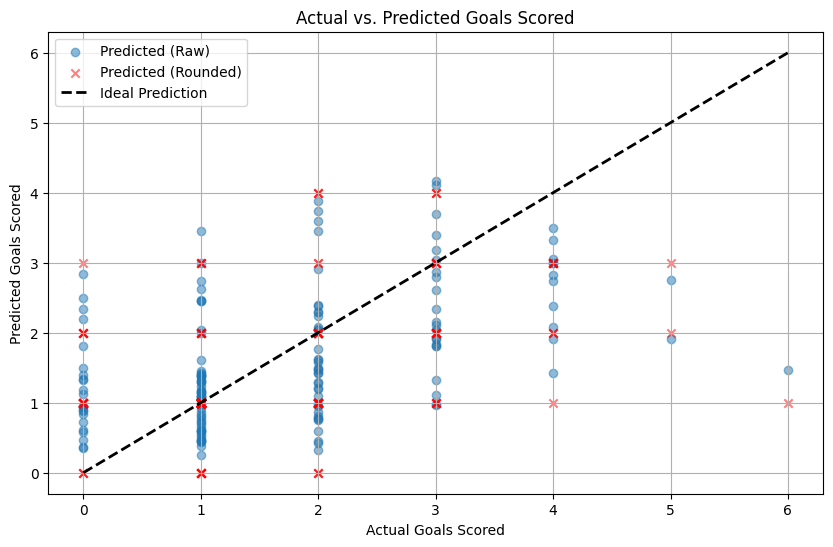

In [48]:
# 2. Make Predictions
y_pred_regr = regressor_model.predict(X_test_regr_scaled)

# Since goals are integers, we can round the predictions (optional, but makes sense for this context)
y_pred_regr_rounded = np.round(y_pred_regr).astype(int)

# 3. Evaluate Performance
mae = mean_absolute_error(y_test_regr, y_pred_regr)
mse = mean_squared_error(y_test_regr, y_pred_regr)
r2 = r2_score(y_test_regr, y_pred_regr)

print(f"Mean Absolute Error (MAE): {mae:.4f} goals")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}\n")

print("Evaluating with rounded predictions (closer to real-world goal counts):")
mae_rounded = mean_absolute_error(y_test_regr, y_pred_regr_rounded)
mse_rounded = mean_squared_error(y_test_regr, y_pred_regr_rounded)
r2_rounded = r2_score(y_test_regr, y_pred_regr_rounded)

print(f"MAE (rounded): {mae_rounded:.4f} goals")
print(f"MSE (rounded): {mse_rounded:.4f}")
print(f"R² (rounded): {r2_rounded:.4f}")

# Visualize actual vs. predicted goals
plt.figure(figsize=(10, 6))
plt.scatter(y_test_regr, y_pred_regr, alpha=0.5, label='Predicted (Raw)')
plt.scatter(y_test_regr, y_pred_regr_rounded, alpha=0.5, color='red', marker='x', label='Predicted (Rounded)')
plt.plot([y_test_regr.min(), y_test_regr.max()], [y_test_regr.min(), y_test_regr.max()], 'k--', lw=2, label='Ideal Prediction')
plt.xlabel('Actual Goals Scored')
plt.ylabel('Predicted Goals Scored')
plt.title('Actual vs. Predicted Goals Scored')
plt.legend()
plt.grid(True)
plt.show()

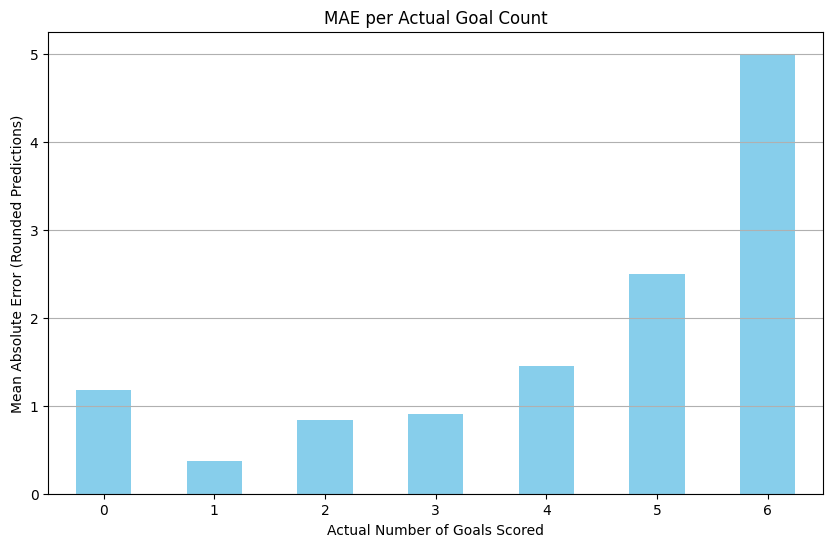


Interpretation of Mean Predicted vs. Actual Goals:
- This plot helps to see if there's a systematic over- or under-prediction for certain goal counts.
- If the orange bars (mean predicted) are consistently below the gray bars (actual) for higher goal counts,
  it means the model tends to under-predict high-scoring games. The opposite for over-prediction.
- The closer the orange bars are to the ideal prediction line (and thus the gray bars), the better calibrated the model is on average for each goal category.



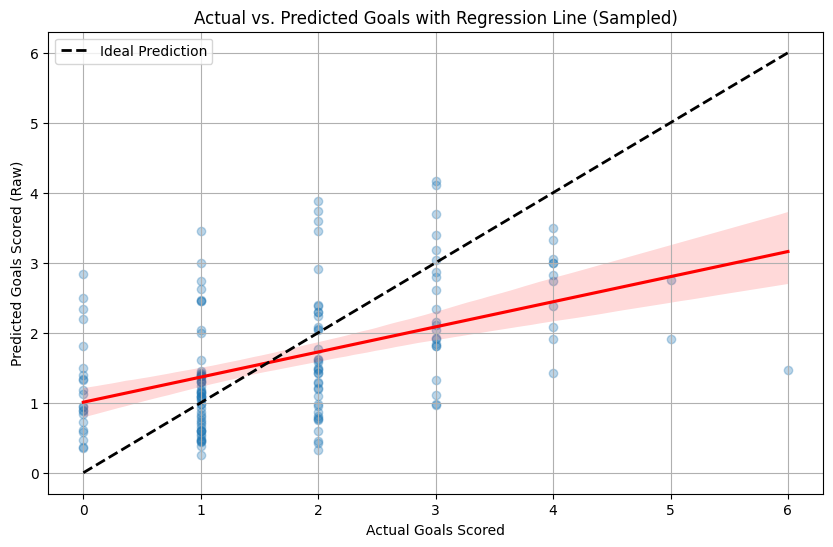


Interpretation of Clearer Scatter Plots:
- `regplot`: Shows the general trend. If the red regression line is close to the black dashed 'Ideal Prediction' line,
  it indicates a good linear relationship. The spread of points around the line shows the variance.
- `hexbin plot`: Useful for very dense scatter plots. Darker hexagons mean more data points fall into that
  actual/predicted goal combination. Ideally, the darkest hexagons would cluster along the 'Ideal Prediction' line.
  This helps see where the bulk of predictions lie.

\n--- Overall Summary of Regression Performance ---
R-squared (R²): 0.1419 (Explains 14.19% of variance in goals scored using raw predictions)
Mean Absolute Error (MAE - Raw): 0.8767 goals (On average, raw predictions are off by this many goals)
Mean Absolute Error (MAE - Rounded): 0.8224 goals (On average, rounded predictions are off by this many goals)

Final Thoughts on Model Performance:
- Predicting exact goal counts in football is notoriously difficult 

In [49]:
# Ensure y_test_regr is a NumPy array or Pandas Series for easy manipulation
if not isinstance(y_test_regr, (np.ndarray, pd.Series)):
    y_test_regr_np = np.array(y_test_regr)
else:
    y_test_regr_np = y_test_regr.to_numpy() if isinstance(y_test_regr, pd.Series) else y_test_regr

if not isinstance(y_pred_regr, (np.ndarray, pd.Series)):
    y_pred_regr_np = np.array(y_pred_regr)
else:
    y_pred_regr_np = y_pred_regr.to_numpy() if isinstance(y_pred_regr, pd.Series) else y_pred_regr
    
if not isinstance(y_pred_regr_rounded, (np.ndarray, pd.Series)):
    y_pred_regr_rounded_np = np.array(y_pred_regr_rounded)
else:
    y_pred_regr_rounded_np = y_pred_regr_rounded.to_numpy() if isinstance(y_pred_regr_rounded, pd.Series) else y_pred_regr_rounded


# Residuals are the differences between actual and predicted values
residuals = y_test_regr_np - y_pred_regr_np # Using raw predictions for residuals


# --- 3. Error Metrics by Actual Goals (using rounded predictions for more intuitive MAE) ---
# Create a DataFrame for easier analysis
results_df = pd.DataFrame({'actual_goals': y_test_regr_np, 'predicted_goals_rounded': y_pred_regr_rounded_np})
results_df['absolute_error'] = abs(results_df['actual_goals'] - results_df['predicted_goals_rounded'])

mae_per_goal_count = results_df.groupby('actual_goals')['absolute_error'].mean()

plt.figure(figsize=(10, 6))
mae_per_goal_count.plot(kind='bar', color='skyblue')
plt.xlabel('Actual Number of Goals Scored')
plt.ylabel('Mean Absolute Error (Rounded Predictions)')
plt.title('MAE per Actual Goal Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


print("""
Interpretation of Mean Predicted vs. Actual Goals:
- This plot helps to see if there's a systematic over- or under-prediction for certain goal counts.
- If the orange bars (mean predicted) are consistently below the gray bars (actual) for higher goal counts,
  it means the model tends to under-predict high-scoring games. The opposite for over-prediction.
- The closer the orange bars are to the ideal prediction line (and thus the gray bars), the better calibrated the model is on average for each goal category.
""")


# --- 5. Clearer Scatter Plot: Seaborn's regplot or a Hexbin Plot ---

# Using regplot for a trend line (can be slow with many points, so let's use a sample if too large)
sample_size = min(len(y_test_regr_np), 1000) # Use at most 1000 points for regplot
indices = np.random.choice(len(y_test_regr_np), sample_size, replace=False)

plt.figure(figsize=(10, 6))
sns.regplot(x=y_test_regr_np[indices], y=y_pred_regr_np[indices], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.plot([y_test_regr_np.min(), y_test_regr_np.max()], [y_test_regr_np.min(), y_test_regr_np.max()], 'k--', lw=2, label='Ideal Prediction')
plt.xlabel('Actual Goals Scored')
plt.ylabel('Predicted Goals Scored (Raw)')
plt.title('Actual vs. Predicted Goals with Regression Line (Sampled)')
plt.legend()
plt.grid(True)
plt.show()


print("""
Interpretation of Clearer Scatter Plots:
- `regplot`: Shows the general trend. If the red regression line is close to the black dashed 'Ideal Prediction' line,
  it indicates a good linear relationship. The spread of points around the line shows the variance.
- `hexbin plot`: Useful for very dense scatter plots. Darker hexagons mean more data points fall into that
  actual/predicted goal combination. Ideally, the darkest hexagons would cluster along the 'Ideal Prediction' line.
  This helps see where the bulk of predictions lie.
""")

# --- Overall Summary of Regression Performance ---
print("\\n--- Overall Summary of Regression Performance ---")
print(f"R-squared (R²): {r2_score(y_test_regr_np, y_pred_regr_np):.4f} (Explains {r2_score(y_test_regr_np, y_pred_regr_np)*100:.2f}% of variance in goals scored using raw predictions)")
print(f"Mean Absolute Error (MAE - Raw): {mean_absolute_error(y_test_regr_np, y_pred_regr_np):.4f} goals (On average, raw predictions are off by this many goals)")
print(f"Mean Absolute Error (MAE - Rounded): {mean_absolute_error(y_test_regr_np, y_pred_regr_rounded_np):.4f} goals (On average, rounded predictions are off by this many goals)")

print("""
Final Thoughts on Model Performance:
- Predicting exact goal counts in football is notoriously difficult due to the sport's inherent randomness and low-scoring nature.
- An R² value significantly above 0 indicates the model has some predictive power beyond just guessing the average. For example, an R² of 0.3-0.5 in this context might be considered reasonable.
- The MAE (especially the rounded one) gives a practical sense of the prediction error. If actual goals are typically 0-3, an MAE around 0.7-1.0 might be typical for such models.
- The plots help identify if the model has systematic biases (e.g., always underpredicting high scores) or if errors are fairly random.
- The xG-based features likely provide a good baseline expectation, but the model will struggle with 'upsets' or unusually high/low scoring games not well-reflected in the xG for that specific match.
""")

### Discussion of Regression Results

Now we are trying to predict the *exact number of goals scored*, which is a more challenging task than predicting just Win/Draw/Loss.

-   **MAE**: This tells us, on average, how far off our predictions are from the actual number of goals. An MAE of 0.8 would mean our predictions are off by about 0.8 goals on average.
-   **MSE**: This metric penalizes larger errors more heavily. It's harder to interpret directly in terms of goals but is useful for comparing models.
-   **R²**: This indicates how much of the variability in actual goals scored is explained by our model. An R² of 0.4 means our model explains 40% of the variance in goals scored. Higher is better (closer to 1).

The scatter plot helps visualize the model's performance. Ideally, points would lie perfectly on the dashed diagonal line.

**Does xG correlate with the number of goals scored?**
If the R² value is reasonably above 0 and the MAE is not excessively high (considering typical goal counts in matches), it suggests that the xG-related features do provide some information for predicting the actual number of goals. However, football is a highly variable sport, and predicting exact goal counts is difficult. There's a lot of randomness (luck, individual brilliance/errors) that xG alone cannot capture.

The model gives us an idea of *expected* performance translating into *actual* goals, but the inherent unpredictability of football will always limit the accuracy of such predictions.